# Rice Type Classification

In [3]:
import torch
import torch.nn as nn
from torch.optim import Adam
from torch.utils.data import Dataset, DataLoader
from torchsummary import summary
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

device = 'cuda' if torch.cuda.is_available() else 'cpu'
print(device)

cuda


In [4]:
df = pd.read_csv('riceClassification.csv')
df.head()

,id,Area,MajorAxisLength,MinorAxisLength,Eccentricity,ConvexArea,EquivDiameter,Extent,Perimeter,Roundness,AspectRation,Class
0,1,4537,92.229316,64.012769,0.719916,4677,76.004525,0.657536,273.085,0.764510,1.440796,1
1,2,2872,74.691881,51.400454,0.725553,3015,60.471018,0.713009,208.317,0.831658,1.453137,1
2,3,3048,76.293164,52.043491,0.731211,3132,62.296341,0.759153,210.012,0.868434,1.465950,1
3,4,3073,77.033628,51.928487,0.738639,3157,62.551300,0.783529,210.657,0.870203,1.483456,1
4,5,3693,85.124785,56.374021,0.749282,3802,68.571668,0.769375,230.332,0.874743,1.510000,1


In [5]:
df.isna().sum()

id                 0
Area               0
MajorAxisLength    0
MinorAxisLength    0
Eccentricity       0
ConvexArea         0
EquivDiameter      0
Extent             0
Perimeter          0
Roundness          0
AspectRation       0
Class              0
dtype: int64

In [6]:
df.drop(['id'], axis=1, inplace=True)

In [7]:
df.shape

(18185, 11)

In [8]:
df.head()

,Area,MajorAxisLength,MinorAxisLength,Eccentricity,ConvexArea,EquivDiameter,Extent,Perimeter,Roundness,AspectRation,Class
0,4537,92.229316,64.012769,0.719916,4677,76.004525,0.657536,273.085,0.764510,1.440796,1
1,2872,74.691881,51.400454,0.725553,3015,60.471018,0.713009,208.317,0.831658,1.453137,1
2,3048,76.293164,52.043491,0.731211,3132,62.296341,0.759153,210.012,0.868434,1.465950,1
3,3073,77.033628,51.928487,0.738639,3157,62.551300,0.783529,210.657,0.870203,1.483456,1
4,3693,85.124785,56.374021,0.749282,3802,68.571668,0.769375,230.332,0.874743,1.510000,1


In [9]:
df['Class'].value_counts()

Class
1    9985
0    8200
Name: count, dtype: int64

In [10]:
X = df.drop(['Class'], axis=1)
y = df['Class']

In [11]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

In [12]:
X_test, X_val, y_test, y_val = train_test_split(X_test, y_test, test_size=0.5, random_state=42)

In [13]:
X_train.shape

(12729, 10)

In [14]:
scaler = StandardScaler()

X_train = scaler.fit_transform(X_train)
X_val = scaler.transform(X_val)
X_test = scaler.transform(X_test)

In [15]:
class dataset(Dataset):
    def __init__(self, X, y):
        self.X = torch.tensor(np.array(X), dtype=torch.float32).to(device)
        self.y = torch.tensor(np.array(y), dtype=torch.float32).to(device)
    
    def __len__(self):
        return len(self.X)

    def __getitem__(self, index):
        return self.X[index], self.y[index]

In [16]:
training_data = dataset(X_train, y_train)
validation_data = dataset(X_val, y_val)
testing_data = dataset(X_test, y_test)

In [17]:
training_dataloader = DataLoader(training_data, batch_size=32, shuffle=True)
validation_dataloader = DataLoader(validation_data, batch_size=32, shuffle=True)
testing_dataloader = DataLoader(testing_data, batch_size=32, shuffle=True)

In [18]:
class Model(nn.Module):
    def __init__(self, hidden_size):
        super().__init__()
        self.input_layer = nn.Linear(X.shape[1], hidden_size)
        self.hidden_layer = nn.Linear(hidden_size, 1)
        self.sigmoid = nn.Sigmoid()

    def forward(self, x):
        x = self.input_layer(x)
        x = self.hidden_layer(x)
        x = self.sigmoid(x)
        return x

In [19]:
model = Model(10).to(device)

In [20]:
summary(model, (X.shape[1], ))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Linear-1                   [-1, 10]             110
            Linear-2                    [-1, 1]              11
           Sigmoid-3                    [-1, 1]               0
Total params: 121
Trainable params: 121
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.00
Forward/backward pass size (MB): 0.00
Params size (MB): 0.00
Estimated Total Size (MB): 0.00
----------------------------------------------------------------


In [21]:
criterion = nn.BCELoss()
optimizer = Adam(model.parameters(), lr=1e-3)

In [22]:
total_loss_train_plot = []
total_loss_val_plot = []
total_acc_train_plot = []
total_acc_val_plot = []

epochs = 10
for epoch in range(epochs):
    total_loss_train = 0
    total_loss_val = 0
    total_acc_train = 0
    total_acc_val = 0

    for inputs, labels in training_dataloader:
        prediction = model(inputs).ravel()
        batch_loss = criterion(prediction, labels)

        total_loss_train += batch_loss.item()
        total_acc_train += ((prediction).round() == labels).sum().item()

        batch_loss.backward()
        optimizer.step()
        optimizer.zero_grad()

    with torch.no_grad():
        for inputs, labels in validation_dataloader:
            prediction = model(inputs).ravel()
            batch_loss = criterion(prediction, labels)

            total_loss_val += batch_loss.item()
            total_acc_val += ((prediction).round() == labels).sum().item()
    
    total_loss_train_plot.append(round(total_loss_train / 1000, 4))
    total_loss_val_plot.append(round(total_loss_val / 1000, 4))
    total_acc_train_plot.append(round(total_acc_train / training_data.__len__() * 100, 4))
    total_acc_val_plot.append(round(total_acc_val / validation_data.__len__() * 100, 4))
    
    print(f'''Epoch: {epoch + 1} Train Loss: {round(total_loss_train / 1000, 4)} Train Accuracy: {round(total_acc_train / training_data.__len__() * 100, 4)}
         Validation Loss: {round(total_loss_val / 1000, 4)} Validation Accuracy: {round(total_acc_val / validation_data.__len__() * 100, 4)}''')



Epoch: 1 Train Loss: 0.0694 Train Accuracy: 95.4906
         Validation Loss: 0.0048 Validation Accuracy: 98.5704
Epoch: 2 Train Loss: 0.0192 Train Accuracy: 98.5152
         Validation Loss: 0.0039 Validation Accuracy: 98.5704
Epoch: 3 Train Loss: 0.0171 Train Accuracy: 98.6173
         Validation Loss: 0.0038 Validation Accuracy: 98.5704
Epoch: 4 Train Loss: 0.0165 Train Accuracy: 98.633
         Validation Loss: 0.004 Validation Accuracy: 98.6437
Epoch: 5 Train Loss: 0.0162 Train Accuracy: 98.633
         Validation Loss: 0.0037 Validation Accuracy: 98.6437
Epoch: 6 Train Loss: 0.016 Train Accuracy: 98.6488
         Validation Loss: 0.0036 Validation Accuracy: 98.6804
Epoch: 7 Train Loss: 0.0158 Train Accuracy: 98.6645
         Validation Loss: 0.0035 Validation Accuracy: 98.6437
Epoch: 8 Train Loss: 0.0157 Train Accuracy: 98.6802
         Validation Loss: 0.0036 Validation Accuracy: 98.6437
Epoch: 9 Train Loss: 0.0156 Train Accuracy: 98.7116
         Validation Loss: 0.0034 Validat

In [23]:
with torch.no_grad():
    total_loss_test = 0
    total_acc_test = 0

    for inputs, labels in testing_dataloader:
        prediction = model(inputs).ravel()
        batch_loss = criterion(prediction, labels)

        total_loss_test += batch_loss.item()
        total_acc_test += ((prediction).round() == labels).sum().item()

print(f'Test Loss: {round(total_loss_test / 1000, 4)} Test Accuracy: {round(total_acc_test / testing_data.__len__() * 100, 4)}')

Test Loss: 0.0022 Test Accuracy: 99.2669


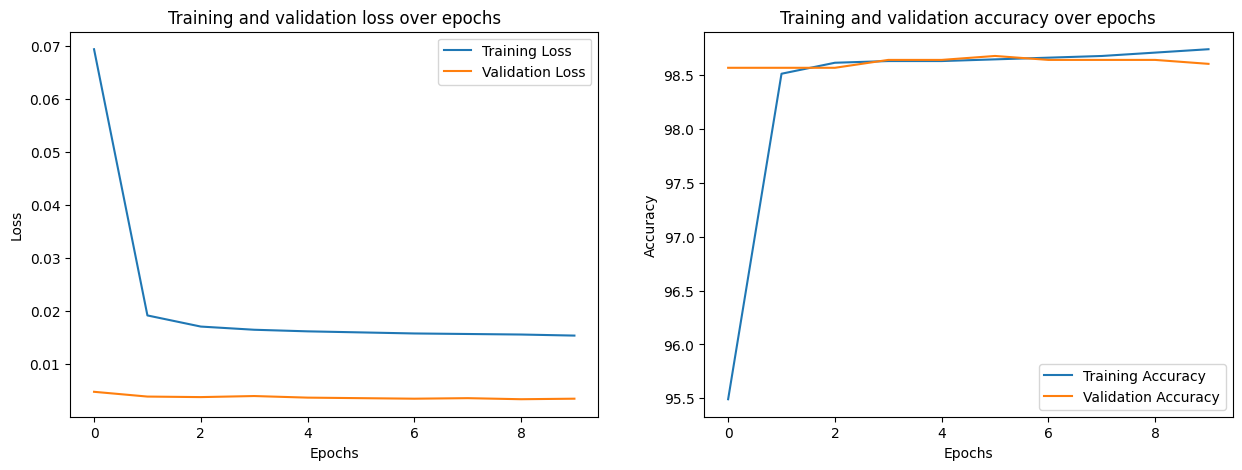

In [24]:
fig, axs = plt.subplots(nrows=1, ncols=2, figsize=(15, 5))
axs[0].plot(total_loss_train_plot, label='Training Loss')
axs[0].plot(total_loss_val_plot, label='Validation Loss')
axs[0].set_title('Training and validation loss over epochs')
axs[0].set_xlabel('Epochs')
axs[0].set_ylabel('Loss')
axs[0].legend()

axs[1].plot(total_acc_train_plot, label='Training Accuracy')
axs[1].plot(total_acc_val_plot, label='Validation Accuracy')
axs[1].set_title('Training and validation accuracy over epochs')
axs[1].set_xlabel('Epochs')
axs[1].set_ylabel('Accuracy')
axs[1].legend()

In [31]:
area = float(input("Area: "))
MajorAxisLength = float(input("Major Axis Length: "))
MinorAxisLength = float(input("Minor Axis Length: "))
Eccentricity = float(input("Eccentricity: "))
ConvexArea = float(input("Convex Area: "))
EquivDiameter = float(input("EquivDiameter: "))
Extent = float(input("Extent: "))
Perimeter = float(input("Perimeter: "))
Roundness = float(input("Roundness: "))
AspectRation = float(input("AspectRation: "))

inputs = np.array([area, MajorAxisLength, MinorAxisLength, Eccentricity, ConvexArea, EquivDiameter, Extent, Perimeter, Roundness, AspectRation]).reshape((1, -1))
scaled_inputs = scaler.transform(inputs)
model_inputs = torch.Tensor(scaled_inputs).to(device)
prediction = (model(model_inputs))
print(prediction)
print("Class is: ", round(prediction.item()))

tensor([[0.6554]], device='cuda:0', grad_fn=<SigmoidBackward0>)
Class is:  1


s:\Data\Coding\Kaggle\venv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


In [ ]:
# Area: 6431.279
# Major Axis Length: 145.21338
# Minor Axis Length: 56.902
# Eccentricity: 0.919981821
# Convex Area: 6518.93759999
# EquivDiameter: 90.483541
# Extent: 0.8506668
# Perimeter: 329.972
# Roundness: 0.742255516
# AspectRation: 2.551696